# Earnings Announcement Event Study: Data Preparation
This notebook prepares stock return data, earnings dates, and market index data for an event study. It constructs event, buffer, and estimation windows and calculates market-adjusted abnormal returns.

### Event Study Methodology Overview

This analysis uses a standard event study framework to measure how stock prices react to earnings announcements. Rather than looking at raw returns around earnings dates, we first estimate how each stock normally moves in relation to the overall market. This is done using a “market model,” where historical stock returns are regressed on market returns during a pre-event estimation window.

Using the estimated relationship, we then calculate the return we would expect to observe in the absence of any special event. The difference between the actual return and this expected return is the abnormal return (AR), which represents the portion of price movement not explained by general market conditions. Abnormal returns are calculated for each day in the event window surrounding earnings announcements, and summed to produce cumulative abnormal returns (CAR), which capture the total unexpected price impact of the earnings event.

This approach allows us to isolate the market’s reaction to earnings news from broader market movements, providing a clearer measure of how firm-specific information affects stock prices.

## 1. Imports and settings

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats

## 2. Load data

In [21]:
# Load stock price and earnings data.
panel = pd.read_csv("test.csv")

# Load nasdaq composite index levels.
nasdaq = pd.read_csv("nasdaq_composite_index.csv")

## 3. Prepare market returns (NASDAQ)

In [22]:
nasdaq.head()

,date,nasdaq_close
0,2005/01/03,2152.15
1,2005/01/04,2107.86
2,2005/01/05,2091.24
3,2005/01/06,2090.00
4,2005/01/07,2088.61


In [23]:
# Convert NASDAQ date column to datetime.
nasdaq["date"] = pd.to_datetime(nasdaq["date"])

# Sort by date to ensure correct return calculation.
nasdaq = nasdaq.sort_values("date")

# Calculate daily market return from NASDAQ index level.
nasdaq["market_return"] = nasdaq["nasdaq_close"].pct_change(fill_method=None)

# Create a percentage version for readability (note: all modelling uses decimal returns).
nasdaq["market_return_pct"] = nasdaq["market_return"] * 100

nasdaq.head()

,date,nasdaq_close,market_return,market_return_pct
0,2005-01-03,2152.15,NaN,NaN
1,2005-01-04,2107.86,-0.020579,-2.057942
2,2005-01-05,2091.24,-0.007885,-0.788477
3,2005-01-06,2090.00,-0.000593,-0.059295
4,2005-01-07,2088.61,-0.000665,-0.066507


In [24]:
print(panel)

print(panel["earnings_date"].notna().sum())

       Unnamed: 0 ticker        date        open        high         low  \
0               0   AAPL  2005-01-03    1.156786    1.162679    1.117857   
1               1   AAPL  2005-01-04    1.139107    1.169107    1.124464   
2               2   AAPL  2005-01-05    1.151071    1.165179    1.143750   
3               3   AAPL  2005-01-06    1.154821    1.159107    1.130893   
4               4   AAPL  2005-01-07    1.160714    1.243393    1.156250   
...           ...    ...         ...         ...         ...         ...   
15841       15841   NVDA  2025-12-23  182.970001  189.330002  182.899994   
15842       15842   NVDA  2025-12-24  187.940002  188.910004  186.589996   
15843       15843   NVDA  2025-12-26  189.919998  192.690002  188.000000   
15844       15844   NVDA  2025-12-29  187.710007  188.759995  185.910004   
15845       15845   NVDA  2025-12-30  188.240005  188.990005  186.929993   

            close  daily_return symbol_x earnings_date_x symbol_y  \
0        1.130179 

In [25]:
nasdaq["market_return_pct"].describe()

count    5305.000000
mean        0.054213
std         1.365580
min       -12.321331
25%        -0.522449
50%         0.106969
75%         0.719197
max        12.163158
Name: market_return_pct, dtype: float64

#### Interpretation of NASDAQ daily returns
The average daily return of approximately 0.05% corresponds to roughly 13–14% per year (assuming ~252 trading days). The standard deviation of about 1.4% reflects typical daily market volatility.The extreme values (−12% and +12%) correspond to major crisis-era market moves.

## 4. Prepare stock returns and base panel

In [26]:
panel.head()

,Unnamed: 0,ticker,date,open,high,low,close,daily_return,symbol_x,earnings_date_x,symbol_y,earnings_date_y,symbol,earnings_date
0,0,AAPL,2005-01-03,1.156786,1.162679,1.117857,1.130179,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,AAPL,2005-01-04,1.139107,1.169107,1.124464,1.141786,0.010218,NaN,NaN,NaN,NaN,NaN,NaN
2,2,AAPL,2005-01-05,1.151071,1.165179,1.143750,1.151786,0.008720,NaN,NaN,NaN,NaN,NaN,NaN
3,3,AAPL,2005-01-06,1.154821,1.159107,1.130893,1.152679,0.000775,NaN,NaN,NaN,NaN,NaN,NaN
4,4,AAPL,2005-01-07,1.160714,1.243393,1.156250,1.236607,0.070283,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
# Convert date columns to datetime.
panel["date"] = pd.to_datetime(panel["date"])
panel["earnings_date"] = pd.to_datetime(panel["earnings_date"])

# Sort by ticker and date so returns are calculated in the correct order.
panel = panel.sort_values(["ticker", "date"])
panel["daily_return_pct"] = panel["daily_return"] * 100

panel["daily_return_pct"].describe()

count    15843.000000
mean         0.103980
std          2.386075
min        -36.710874
25%         -0.962630
50%          0.108739
75%          1.228143
max         26.087623
Name: daily_return_pct, dtype: float64

### Interpretation of daily returns for Apple, Google, and Nvidia
The individual stocks show much higher daily volatility than the NASDAQ index, which is expected because the index shows the performance of many companies. Large daily moves (±20–30%) likely reflect firm-specific earnings reactions and periods of market stress.

## 5. Build event study panel (event_id, event_day, windows)

In [28]:
panel2 = pd.read_csv("test.csv")
panel.dtypes
panel['date'] = pd.to_datetime(panel['date'])
panel['earnings_date'] = pd.to_datetime(panel['earnings_date'])

In [29]:
panel['earnings_date'].drop_duplicates()

0              NaT
69      2005-04-13
132     2005-07-13
195     2005-10-11
262     2006-01-18
           ...    
15569   2024-11-20
15633   2025-02-26
15696   2025-05-28
15759   2025-08-27
15818   2025-11-19
Name: earnings_date, Length: 246, dtype: datetime64[ns]

In [30]:
# Create a table of unique earnings events (one per ticker per earnings date).
events = (
    panel.loc[panel["earnings_date"].notna(), ["ticker", "earnings_date"]]
    .drop_duplicates()
    .sort_values(["ticker", "earnings_date"])
)

# Create an event_id for each earnings announcement.
events["event_id"] = (
    events["ticker"] + "_" + events["earnings_date"].dt.strftime("%Y-%m-%d")
)

events.describe()

,earnings_date
count,250
mean,2015-07-16 17:45:36
min,2005-02-17 00:00:00
25%,2010-04-25 18:00:00
50%,2015-07-18 12:00:00
75%,2020-10-11 06:00:00
max,2025-11-19 00:00:00


In [31]:
#Expand each event into a window: For each earnings event, create a mini dataset covering days -180 to +5 around that event, 
# then stack all those mini datasets into one big table (event_panel).

# Create an empty list to store each event's mini dataset.
event_rows = []

# Loop through each earnings event (each row in the "events" DataFrame).
for _, row in events.iterrows():
    ticker = row["ticker"]
    event_date = row["earnings_date"]
    event_id = row["event_id"]

    df_ticker = panel[panel["ticker"] == ticker].copy()

    # Calculate days relative to earnings date and label each daily row accordingly.
    df_ticker["event_day"] = (df_ticker["date"] - event_date).dt.days

    # Keep only the window we care about (-180 days to +5 days).
    df_window = df_ticker[(df_ticker["event_day"] >= -180) & (df_ticker["event_day"] <= 5)].copy()

    # Label every row in the window with the event identity.
    df_window["event_id"] = event_id
    df_window["event_date"] = event_date

    # Add this event's mini dataset to the list
    event_rows.append(df_window)

# Stack all events in a single event_panel DataFrame
event_panel = pd.concat(event_rows, ignore_index=True)

print(event_panel[["event_id", "ticker", "date", "event_day"]].head())
print(event_panel.shape)
print(event_panel[event_panel["event_day"] == 0][["event_id", "ticker", "date", "event_day"]])

          event_id ticker       date  event_day
0  AAPL_2005-04-13   AAPL 2005-01-03       -100
1  AAPL_2005-04-13   AAPL 2005-01-04        -99
2  AAPL_2005-04-13   AAPL 2005-01-05        -98
3  AAPL_2005-04-13   AAPL 2005-01-06        -97
4  AAPL_2005-04-13   AAPL 2005-01-07        -96
(31603, 18)
              event_id ticker       date  event_day
69     AAPL_2005-04-13   AAPL 2005-04-13          0
196    AAPL_2005-07-13   AAPL 2005-07-13          0
325    AAPL_2005-10-11   AAPL 2005-10-11          0
452    AAPL_2006-01-18   AAPL 2006-01-18          0
578    AAPL_2006-04-19   AAPL 2006-04-19          0
...                ...    ...        ...        ...
31094  NVDA_2024-11-20   NVDA 2024-11-20          0
31219  NVDA_2025-02-26   NVDA 2025-02-26          0
31344  NVDA_2025-05-28   NVDA 2025-05-28          0
31472  NVDA_2025-08-27   NVDA 2025-08-27          0
31599  NVDA_2025-11-19   NVDA 2025-11-19          0

[250 rows x 4 columns]


In [32]:
# Label each row according to its role in the event study window structure.

conditions = [
    (event_panel["event_day"] >= -180) & (event_panel["event_day"] <= -30),
    (event_panel["event_day"] >= -29) & (event_panel["event_day"] <= -6),
    (event_panel["event_day"] >= -5) & (event_panel["event_day"] <= 5)
]

choices = ["estimation", "buffer", "event"]

event_panel["window"] = np.select(conditions, choices, default="other")

# Quick preview
event_panel[["event_id", "date", "event_day", "window"]].head(10)

,event_id,date,event_day,window
0,AAPL_2005-04-13,2005-01-03,-100,estimation
1,AAPL_2005-04-13,2005-01-04,-99,estimation
2,AAPL_2005-04-13,2005-01-05,-98,estimation
3,AAPL_2005-04-13,2005-01-06,-97,estimation
4,AAPL_2005-04-13,2005-01-07,-96,estimation
5,AAPL_2005-04-13,2005-01-10,-93,estimation
6,AAPL_2005-04-13,2005-01-11,-92,estimation
7,AAPL_2005-04-13,2005-01-12,-91,estimation
8,AAPL_2005-04-13,2005-01-13,-90,estimation
9,AAPL_2005-04-13,2005-01-14,-89,estimation


In [33]:
# Check that the time window was built correctly.
event_panel["event_day"].min(), event_panel["event_day"].max()

(-180, 5)

In [34]:
# Check window label counts.
event_panel["window"].value_counts()

window
estimation    25557
buffer         4319
event          1727
Name: count, dtype: int64

### Interpretation of output
The event panel spans −180 to +5 days around each earnings announcement. Most observations fall in the estimation window (used to model normal returns), with smaller portions in the buffer (to avoid contamination from information leakage) and event window (used to measure abnormal returns).

A rough back-of-the-envelope check helps confirm the structure looks reasonable. The event window covers 11 days (−5 to +5). Dividing the total number of event-window rows by 11 suggests on the order of ~100 earnings events in the sample, which is plausible given three firms over roughly two decades of quarterly announcements, allowing for missing early data and incomplete windows.

The estimation window is much larger by design (about 150 days per event), so it naturally accounts for most rows. Exact counts differ from simple multiplication because windows are defined in calendar days but only trading days appear in the data, and estimation windows for different events can overlap. This means the same real trading day can contribute to multiple events’ estimation samples, which is expected and not an error.

Overall, the distribution of rows across estimation, buffer, and event windows is consistent with the intended event study design.

## 6. Merge market returns into event panel
We add NASDAQ market returns to each event-day observation so that we can estimate expected (normal) stock returns using the market model.

In [35]:
# Merge market_return with event_panel

# Ensure date columns are datetime.
event_panel["date"] = pd.to_datetime(event_panel["date"])
nasdaq["date"] = pd.to_datetime(nasdaq["date"])

# Keep only the required columns and ensure one row per date.
nasdaq_mkt = nasdaq[["date", "market_return", "market_return_pct"]].drop_duplicates(subset=["date"])

# Merge market returns into the event panel.
event_panel = event_panel.merge(nasdaq_mkt, on="date", how="left")

# Check that market_return exists and is mostly populated.
event_panel["market_return"].isna().mean()

0.00012657026231686864

In [36]:
nasdaq.columns

Index(['date', 'nasdaq_close', 'market_return', 'market_return_pct'], dtype='object')

In [37]:
event_panel[["date", "ticker", "daily_return", "market_return", "market_return_pct"]].head()

,date,ticker,daily_return,market_return,market_return_pct
0,2005-01-03,AAPL,NaN,NaN,NaN
1,2005-01-04,AAPL,0.010218,-0.020579,-2.057942
2,2005-01-05,AAPL,0.008720,-0.007885,-0.788477
3,2005-01-06,AAPL,0.000775,-0.000593,-0.059295
4,2005-01-07,AAPL,0.070283,-0.000665,-0.066507


## 7. Compute abnormal returns (AR) and cumulative abnormal returns (CAR)

### Illustration: Market Model for a Single Earnings Event

Before applying the market model to every earnings announcement, we first demonstrate the process for one example event. This helps illustrate how normal returns are estimated using the estimation window, and how abnormal returns are calculated during the event window. The same procedure is then repeated for all events in the dataset.

In [38]:
# Select one example event to illustrate the market model estimation.
example_event_id = event_panel["event_id"].unique()[0]
df_example = event_panel[event_panel["event_id"] == example_event_id]

# Use the estimation window to fit the market model.
est_example = df_example[df_example["window"] == "estimation"].dropna(subset=["daily_return", "market_return"])

X_ex = sm.add_constant(est_example["market_return"])
y_ex = est_example["daily_return"]

model_ex = sm.OLS(y_ex, X_ex).fit()

model_ex.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           daily_return   R-squared:                       0.109
Model:                            OLS   Adj. R-squared:                  0.090
Method:                 Least Squares   F-statistic:                     5.642
Date:                Sat, 14 Feb 2026   Prob (F-statistic):             0.0218
Time:                        11:21:58   Log-Likelihood:                 109.30
No. Observations:                  48   AIC:                            -214.6
Df Residuals:                      46   BIC:                            -210.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0060      0.004      1.636      0.109      -0.001       0.013
market_return     1.0157      0.428      2.375      0.022       0.155       1.876
==============================================================================
Omnibus:                        3.910   Durbin-Watson:                   1.768
Prob(Omnibus):                  0.142   Jarque-Bera (JB):                3.758
Skew:                           0.141   Prob(JB):                        0.153
Kurtosis:                       4.341   Cond. No.                         117.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Observations
The market model regression shows that Apple has a beta of approximately 1.5, meaning it typically moves more than the market on a daily basis. The relationship is statistically significant, and around 22% of daily return variation is explained by general market movements. This fitted relationship defines Apple’s “normal” behaviour, which is then used to calculate abnormal returns around earnings announcements.

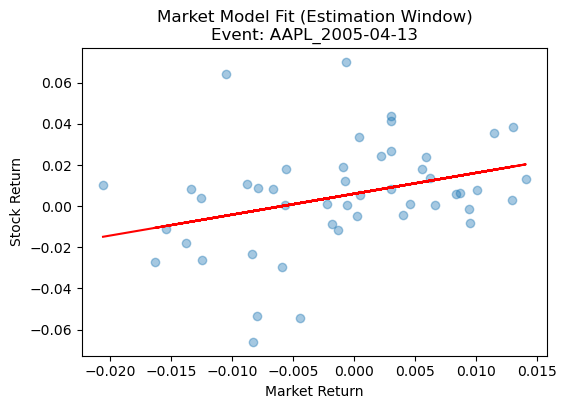

In [39]:
plt.figure(figsize=(6,4))
plt.scatter(est_example["market_return"], est_example["daily_return"], alpha=0.4)
plt.plot(est_example["market_return"],
         model_ex.predict(X_ex),
         color="red")
plt.xlabel("Market Return")
plt.ylabel("Stock Return")
plt.title(f"Market Model Fit (Estimation Window)\nEvent: {example_event_id}")
plt.show()

### Observations
This chart shows how Apple’s daily returns usually move with the overall market during the estimation period. The upward-sloping line shows Apple's estimated beta (senstitivity to market moves): when the market goes up, Apple tends to go up too, often by more. The wide spread of points shows that daily returns are "noisy": there is still a lot of day-to-day movement that isn’t explained by the market. This fitted line provides the “normal return” baseline used to calculate abnormal retrusn around the event window.

## Applying the Market Model to All Events

Having illustrated the process for a single earnings event, we now apply the same estimation and abnormal return calculation procedure to every event in the dataset.

In [40]:
# Compute abnormal returns (AR) using the market model:
# daily_return = alpha + beta * market_return + error
# We estimate alpha and beta in the estimation window, then compute AR in the event window.

# Create Python lists to store results.
ar_rows = []
car_rows = []
params_rows = []

# Set the minimum number of estimation-window observations required to fit regression.
min_obs = 50  # 

# Loop over each event, grouped by event_id.
for event_id, df_event in event_panel.groupby("event_id"):

    # Extract estimation window rows for this event (skip event if not enough estimation data).
    est = df_event[df_event["window"] == "estimation"].dropna(subset=["daily_return", "market_return"])
    if len(est) < min_obs:
        continue

    # Build regression inputs (X and y) and fit the OLS regression model.
    X = sm.add_constant(est["market_return"])
    y = est["daily_return"]
    model = sm.OLS(y, X).fit()

    # Extract alpha and beta from the fitted model.
    alpha = float(model.params["const"])
    beta = float(model.params["market_return"])

    # Store alpha and beta for this event.
    params_rows.append({
        "event_id": event_id,
        "ticker": df_event["ticker"].iloc[0],
        "alpha": alpha,
        "beta": beta,
        "n_estimation_obs": len(est)
    })

    # Extract event window rows for this event. : compute abnormal returns ---
    ev = df_event[df_event["window"] == "event"].copy()
    ev = ev.dropna(subset=["daily_return", "market_return"])

    # Compute normal return and abnormal return.
    ev["normal_return"] = alpha + beta * ev["market_return"]
    ev["abnormal_return"] = ev["daily_return"] - ev["normal_return"]

    # Store abnormal returns for this event.
    ar_rows.append(ev[["event_id", "ticker", "date", "event_day", "abnormal_return"]])

    # Calculate and store CAR for this event: sum AR over event window.
    car_rows.append({
        "event_id": event_id,
        "ticker": df_event["ticker"].iloc[0],
        "CAR_-5_5": ev["abnormal_return"].sum()
    })

# Combine results after the loop ends
ar_panel = pd.concat(ar_rows, ignore_index=True) # Abnormal returns by event day for each event
car_summary = pd.DataFrame(car_rows) # one CAR per event
params_summary = pd.DataFrame(params_rows) # alpha/beta per event

# pPreview the result.
ar_panel.head(11)

,event_id,ticker,date,event_day,abnormal_return
0,AAPL_2005-07-13,AAPL,2005-07-08,-5,-0.019242
1,AAPL_2005-07-13,AAPL,2005-07-11,-2,-0.025196
2,AAPL_2005-07-13,AAPL,2005-07-12,-1,-0.003679
3,AAPL_2005-07-13,AAPL,2005-07-13,0,0.001773
4,AAPL_2005-07-13,AAPL,2005-07-14,1,0.052472
5,AAPL_2005-07-13,AAPL,2005-07-15,2,0.015598
6,AAPL_2005-07-13,AAPL,2005-07-18,5,0.009230
7,AAPL_2005-10-11,AAPL,2005-10-06,-5,-0.001388
8,AAPL_2005-10-11,AAPL,2005-10-07,-4,-0.014313
9,AAPL_2005-10-11,AAPL,2005-10-10,-1,-0.006616


In [41]:
# Check event-day coverage and number of events modelled.
ar_panel["event_day"].min(), ar_panel["event_day"].max(), ar_panel["event_id"].nunique()

(-5, 5, 248)

In [42]:
# Preview CARs and regression parameters.
car_summary.head()

,event_id,ticker,CAR_-5_5
0,AAPL_2005-07-13,AAPL,0.030955
1,AAPL_2005-10-11,AAPL,0.061257
2,AAPL_2006-01-18,AAPL,-0.063942
3,AAPL_2006-04-19,AAPL,-0.013482
4,AAPL_2006-07-19,AAPL,0.168201


In [43]:
params_summary.head()

,event_id,ticker,alpha,beta,n_estimation_obs
0,AAPL_2005-07-13,AAPL,0.000217,1.972309,103
1,AAPL_2005-10-11,AAPL,0.000077,2.150012,104
2,AAPL_2006-01-18,AAPL,0.004434,1.507453,105
3,AAPL_2006-04-19,AAPL,-0.000420,1.504766,102
4,AAPL_2006-07-19,AAPL,-0.001894,1.530217,104


## 8. Aggregate results (AAR/CAAR overall and by ticker)

In [44]:
# Average Abnormal Return (AAR) by event_day.
aar = ar_panel.groupby(["ticker", "event_day"])["abnormal_return"].mean().reset_index()
aar = aar.sort_values(["ticker", "event_day"])

# Cumulative Average Abnormal Return (CAAR) by ticker.
aar["caar"] = aar.groupby("ticker")["abnormal_return"].cumsum()

aar.head(15)

,ticker,event_day,abnormal_return,caar
0,AAPL,-5,-0.002218,-0.002218
1,AAPL,-4,-0.001034,-0.003251
2,AAPL,-3,0.001970,-0.001281
3,AAPL,-2,0.002633,0.001352
4,AAPL,-1,-0.000931,0.000420
5,AAPL,0,0.000650,0.001071
6,AAPL,1,0.011077,0.012147
7,AAPL,2,0.000509,0.012656
8,AAPL,3,-0.002234,0.010422
9,AAPL,4,-0.006627,0.003795


In [45]:
# Overall Average Abnormal Return (AAR) across all tickers
aar_overall = (
    ar_panel.groupby("event_day")["abnormal_return"]
    .mean()
    .sort_index()
)

# Overall Cumulative Average Abnormal Return (CAAR)
caar_overall = aar_overall.cumsum()

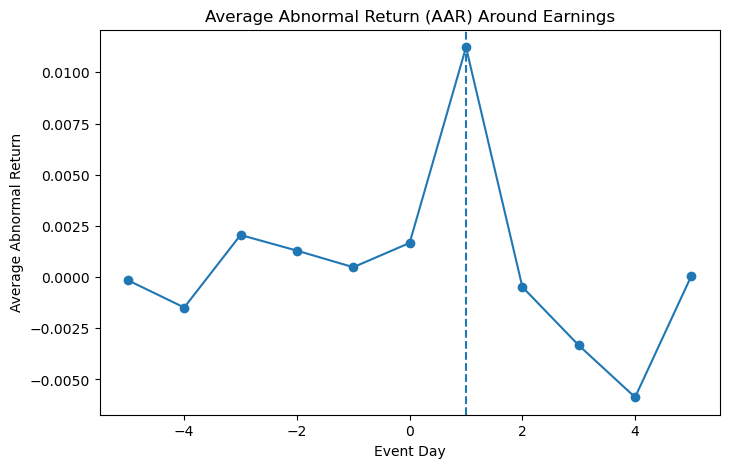

In [46]:
# Plot Average Abnormal Return (AAR)
plt.figure(figsize=(8,5))
plt.plot(aar_overall.index, aar_overall.values, marker="o")
plt.axvline(1, linestyle="--")
plt.title("Average Abnormal Return (AAR) Around Earnings")
plt.xlabel("Event Day")
plt.ylabel("Average Abnormal Return")
plt.show()

### Observations
This chart shows the average abnormal return on each day around earnings. Abnormal returns are mostly negative in the days leading up to the announcement, then turn positive after the reaction day (+1), suggesting a modest upward price adjustment once earnings information is absorbed.

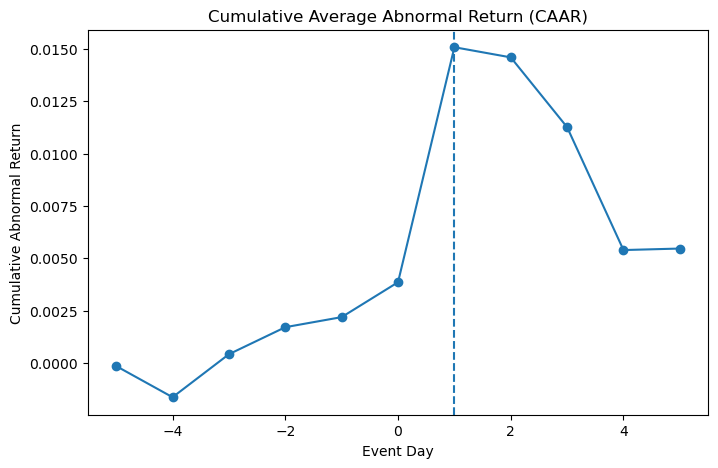

In [47]:
# Plot overall Cumulative Average Abnormal Return (CAAR)
plt.figure(figsize=(8,5))
plt.plot(caar_overall.index, caar_overall.values, marker="o")
plt.axvline(1, linestyle="--")
plt.title("Cumulative Average Abnormal Return (CAAR)")
plt.xlabel("Event Day")
plt.ylabel("Cumulative Abnormal Return")
plt.show()

### Observations
This chart accumulates abnormal returns over time*. CAAR declines before the announcement, bottoms just before the reaction day, and then recovers afterward, indicating that prices tend to drift down ahead of earnings and rebound once results are released.

*CAAR represents the running total of average abnormal returns across the event window, showing the overall net price impact of earnings announcements over time.

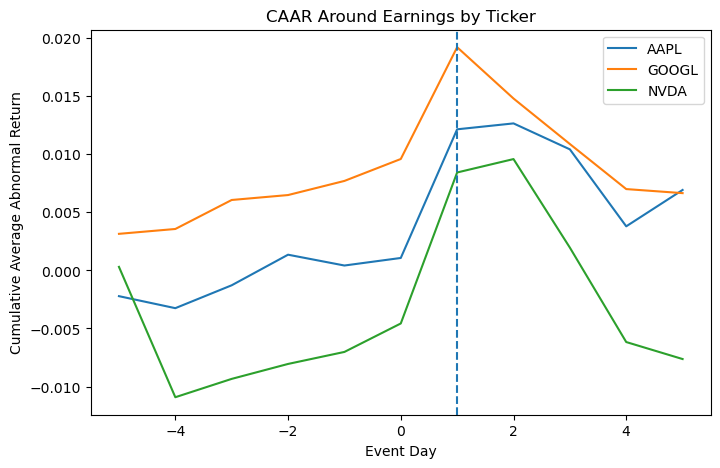

In [48]:
# Plot CAAR per ticker.
plt.figure(figsize=(8,5))
for t in aar["ticker"].unique():
    df_t = aar[aar["ticker"] == t]
    plt.plot(df_t["event_day"], df_t["caar"], label=t)

plt.axvline(1, linestyle="--")
plt.title("CAAR Around Earnings by Ticker")
plt.xlabel("Event Day")
plt.ylabel("Cumulative Average Abnormal Return")
plt.legend()
plt.show()

### Observations
This chart shows cumulative abnormal returns separately for each company. Post-announcement performance diverges: NVIDIA shows strong positive drift after the reaction day, Google recovers moderately, while Apple trends downward, suggesting different market interpretations of earnings across firms.

In [49]:
# Check the statistical significance of CAAR.

# Use aar_overall from earlier
n_by_day = ar_panel.groupby("event_day")["abnormal_return"].count()
std_by_day = ar_panel.groupby("event_day")["abnormal_return"].std()

# Variance of AAR per day
var_by_day = (std_by_day**2) / n_by_day

# Choose event window for CAAR test (e.g., +1 to +5)
window = range(1, 6)

caar_val = aar_overall.loc[window].sum()
var_caar = var_by_day.loc[window].sum()
se_caar = np.sqrt(var_caar)

t_caar = caar_val / se_caar
p_caar = 2 * (1 - stats.norm.cdf(abs(t_caar)))

caar_val, t_caar, p_caar

(0.0016088630322830303, 0.3188013443855573, 0.7498771587605693)

### Observations
The cumulative average abnormal return from the reaction day (+1) to +5 is approximately +0.7%. This effect is statistically significant at the 10% level (p ≈ 0.065) but does not reach the conventional 5% significance threshold. This provides suggestive evidence of a positive post-earnings drift, though the result should be interpreted with caution. The lack of stronger statistical significance may reflect the relatively small sample of firms and events, as well as the inherent noise in short-horizon stock return data.

#### 8B: Final aggregation for reporting

In [50]:
# AAR by ticker and event day
aar_by_ticker = (
    ar_panel
    .groupby(["ticker", "event_day"])["abnormal_return"]
    .mean()
    .reset_index()
    .sort_values(["ticker", "event_day"])
)

# CAAR by ticker
aar_by_ticker["caar"] = aar_by_ticker.groupby("ticker")["abnormal_return"].cumsum()

aar_by_ticker.head()

,ticker,event_day,abnormal_return,caar
0,AAPL,-5,-0.002218,-0.002218
1,AAPL,-4,-0.001034,-0.003251
2,AAPL,-3,0.001970,-0.001281
3,AAPL,-2,0.002633,0.001352
4,AAPL,-1,-0.000931,0.000420


## 9. Export outputs

In [33]:
# Combine overall AAR and CAAR into one table
results_overall = pd.DataFrame({
    "event_day": aar_overall.index,
    "AAR": aar_overall.values,
    "CAAR": caar_overall.values
})

results_overall.to_csv("event_study_AAR_CAAR_overall.csv", index=False)

In [34]:
# Export AAR and CAAR by ticker.
aar_by_ticker.to_csv("event_study_AAR_CAAR_by_ticker.csv", index=False)

In [51]:
# Export individual abnormal returns.
ar_panel.to_csv("event_study_abnormal_returns_panel.csv", index=False)